## Data Processing

In [1]:
SEQ_LEN_IN = 128
SEQ_LEN_OUT = 10
NUM_FEATURES_IN = 121
NUM_FEATURES_OUT = 121
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
BATCH_SIZE = 128
EPOCHS = 1000
PATIENCE = 15

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import similaritymeasures
import impedance
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load
import keras
from sklearn.model_selection import train_test_split

2025-11-10 07:57:24.019356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 07:57:24.049310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 07:57:24.697908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os, glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump

# --- Parametri ---
BLOCK_SIZE = 64
N_BINS_SOH = 5

print("--- Fase 1: Caricamento e preparazione dei dati ---")
files = glob.glob("curves/cell*.csv")
dataframes = []
for path in files:
    cell = os.path.basename(path).split('.')[0]
    df = pd.read_csv(path)
    df.drop(columns=[col for col in df.columns if col.startswith('f_')], inplace=True)
    df.drop(columns=["id", "temperature", "soc", "cell"], errors='ignore', inplace=True)
    df['Cell'] = cell
    dataframes.append(df)

df_all = pd.concat(dataframes, ignore_index=True)
feature_cols = [col for col in df_all.columns if col != 'Cell']

# -----------------------------------------------------------------
print(f"\n--- Fase 2: Creazione di blocchi (dimensione: {BLOCK_SIZE} cicli) ---")

X_blocks, y_blocks = [], []
cell_id_per_block = []
soh_avg_per_block = []

scalers_per_cell = {}

def create_all_sequences(data, seq_len_in, seq_len_out):
    """
    Ritorna (X_enc, y) per modello encoder-only (no decoder input).
      - X_enc: (N, seq_len_in, n_feat_in)
      - y    : (N, seq_len_out, n_feat_out)
    """
    X_enc, y = [], []
    T = len(data)
    win = seq_len_in + seq_len_out
    if T < win:
        return None, None

    for i in range(T - win + 1):
        enc_seq = data[i : i + seq_len_in]
        target  = data[i + seq_len_in : i + seq_len_in + seq_len_out]
        X_enc.append(enc_seq)
        y.append(target)

    return np.array(X_enc), np.array(y)


for cell_id, group in df_all.groupby('Cell'):
    print(f"Processando cella: {cell_id}")
    scaler = StandardScaler()
    data_to_scale = group[feature_cols].values
    
    if len(data_to_scale) < SEQ_LEN_IN + SEQ_LEN_OUT:
        print(f"  -> Dati insufficienti per {cell_id}. Saltato.")
        continue
        
    data_cell_scaled = scaler.fit_transform(data_to_scale)
    scalers_per_cell[cell_id] = scaler

    X_enc_cell, y_cell = create_all_sequences(data_cell_scaled, SEQ_LEN_IN, SEQ_LEN_OUT)
    if X_enc_cell is None:
        continue

    num_sequences_in_cell = len(X_enc_cell)
    for i in range(0, num_sequences_in_cell, BLOCK_SIZE):
        start_idx = i
        end_idx = i + BLOCK_SIZE
        if end_idx > num_sequences_in_cell:
            continue

        X_blocks.append(X_enc_cell[start_idx:end_idx])
        y_blocks.append(y_cell[start_idx:end_idx])
        cell_id_per_block.append(cell_id)
        soh_avg_per_block.append(np.mean(y_cell[start_idx:end_idx, :, -1]))

dump(scalers_per_cell, 'scalers_per_cell.joblib')
print(f"Creati {len(X_blocks)} blocchi totali.")

# -----------------------------------------------------------------
soh_bins = pd.cut(soh_avg_per_block, bins=N_BINS_SOH, labels=False)
# -----------------------------------------------------------------
print("\n--- Fase 3: Esecuzione dello split stratificato sui blocchi (Cell + Bin SoH) ---")

# Creiamo il DataFrame per la stratificazione
df_strata = pd.DataFrame({
    "Cell": cell_id_per_block,
    "Bin": soh_bins
})

# 🔹 Rimuoviamo eventuali righe con NaN nei bin
mask_valid = df_strata["Bin"].notna()
df_strata = df_strata[mask_valid].reset_index(drop=True)
valid_indices = np.where(mask_valid)[0]

# Aggiorniamo tutte le strutture per coerenza
soh_bins = soh_bins[valid_indices]
soh_avg_per_block = [soh_avg_per_block[i] for i in valid_indices]
cell_id_per_block = [cell_id_per_block[i] for i in valid_indices]
X_blocks = [X_blocks[i] for i in valid_indices]
y_blocks = [y_blocks[i] for i in valid_indices]

# 🔹 Creazione dell'etichetta combinata Cell + Bin
df_strata["Strata"] = df_strata["Cell"].astype(str) + "_" + df_strata["Bin"].astype(str)

# 🔹 Rimozione combinazioni Cell+Bin troppo piccole
min_samples_per_class = 2
counts = df_strata["Strata"].value_counts()
rare_classes = counts[counts < min_samples_per_class].index.tolist()

if len(rare_classes) > 0:
    print(f"Rimuovo {len(rare_classes)} combinazioni troppo piccole (< {min_samples_per_class} campioni):")
    print(rare_classes[:10], "..." if len(rare_classes) > 10 else "")
    
    mask_keep = ~df_strata["Strata"].isin(rare_classes)
    df_strata = df_strata[mask_keep].reset_index(drop=True)
    keep_indices = np.where(mask_keep)[0]

    soh_bins = soh_bins[keep_indices]
    soh_avg_per_block = [soh_avg_per_block[i] for i in keep_indices]
    cell_id_per_block = [cell_id_per_block[i] for i in keep_indices]
    X_blocks = [X_blocks[i] for i in keep_indices]
    y_blocks = [y_blocks[i] for i in keep_indices]

print(f"Dopo filtraggio: {len(df_strata)} blocchi validi, {df_strata['Strata'].nunique()} combinazioni Cell+Bin")

# -----------------------------------------------------------------
# 🔹 Split stratificato combinato (train/val/test)

# Indici coerenti con df_strata
indices = np.arange(len(df_strata))

train_val_indices, test_indices = train_test_split(
    indices,
    test_size=(1 - TRAIN_SPLIT - VAL_SPLIT),
    stratify=df_strata["Strata"],
    random_state=42
)

# Split secondario (train vs val)
strata_train_val = df_strata.iloc[train_val_indices]["Strata"]

train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT),
    stratify=strata_train_val,
    random_state=42
)

print(f"\nBlocchi TRAIN: {len(train_indices)}, VAL: {len(val_indices)}, TEST: {len(test_indices)}")


# -----------------------------------------------------------------
print("\n--- Fase 4: Costruzione dei set di training, validazione e test ---")

def build_dataset_from_blocks(indices, x_b, y_b, cell_ids_b):
    if len(indices) == 0:
        return np.array([]), np.array([]), np.array([])
    
    X_enc = np.concatenate([x_b[i] for i in indices], axis=0)
    y = np.concatenate([y_b[i] for i in indices], axis=0)
    
    cell_ids_list = []
    for i in indices:
        cell_ids_list.extend([cell_ids_b[i]] * len(y_b[i]))
    
    return X_enc, y, np.array(cell_ids_list)

X_train_enc, y_train, cell_ids_train = build_dataset_from_blocks(train_indices, X_blocks, y_blocks, cell_id_per_block)
X_val_enc, y_val, cell_ids_val = build_dataset_from_blocks(val_indices, X_blocks, y_blocks, cell_id_per_block)
X_test_enc, y_test, cell_ids_test = build_dataset_from_blocks(test_indices, X_blocks, y_blocks, cell_id_per_block)

# -----------------------------------------------------------------
print("\n--- Fase 5: Mescolamento delle sequenze all'interno dei set ---\n")

def shuffle_sets(*arrays):
    if not all(len(arr) > 0 for arr in arrays):
        return arrays
    idx = np.random.permutation(len(arrays[0]))
    return [arr[idx] for arr in arrays]

X_train_enc, y_train, cell_ids_train = shuffle_sets(X_train_enc, y_train, cell_ids_train)
X_val_enc, y_val, cell_ids_val = shuffle_sets(X_val_enc, y_val, cell_ids_val)

print(f"Forma finale X_train_enc: {X_train_enc.shape}")
print(f"Forma finale y_train: {y_train.shape}")
print(f"Forma finale X_val_enc: {X_val_enc.shape}")
print(f"Forma finale y_val: {y_val.shape}")
print(f"Forma X_test_enc: {X_test_enc.shape}")
print(f"Forma y_test: {y_test.shape}")
print(f"Forma cell_ids_test: {cell_ids_test.shape}")


--- Fase 1: Caricamento e preparazione dei dati ---

--- Fase 2: Creazione di blocchi (dimensione: 64 cicli) ---
Processando cella: cell_1_good
Processando cella: cell_2_good
Processando cella: cell_5_good
Creati 91 blocchi totali.

--- Fase 3: Esecuzione dello split stratificato sui blocchi (Cell + Bin SoH) ---
Rimuovo 4 combinazioni troppo piccole (< 2 campioni):
['cell_1_good_1', 'cell_5_good_4', 'cell_5_good_1', 'cell_5_good_0'] 
Dopo filtraggio: 87 blocchi validi, 10 combinazioni Cell+Bin

Blocchi TRAIN: 60, VAL: 13, TEST: 14

--- Fase 4: Costruzione dei set di training, validazione e test ---

--- Fase 5: Mescolamento delle sequenze all'interno dei set ---

Forma finale X_train_enc: (3840, 128, 121)
Forma finale y_train: (3840, 10, 121)
Forma finale X_val_enc: (832, 128, 121)
Forma finale y_val: (832, 10, 121)
Forma X_test_enc: (896, 128, 121)
Forma y_test: (896, 10, 121)
Forma cell_ids_test: (896,)


In [4]:
def complex_mse_loss(y_true, y_pred):
    """
    Calcola l'errore quadratico medio sul piano complesso.
    Questo forza il modello a imparare la relazione tra parte reale e immaginaria.
    """

    r_idx = tf.constant(list(range(0, 118, 2)))
    i_idx = tf.constant(list(range(1, 118, 2)))

    # tf.gather permette di selezionare colonne specifiche da un tensore
    re_true = tf.gather(y_true, r_idx, axis=-1)
    im_true = tf.gather(y_true, i_idx, axis=-1)

    re_pred = tf.gather(y_pred, r_idx, axis=-1)
    im_pred = tf.gather(y_pred, i_idx, axis=-1)

    z_true = tf.complex(re_true, im_true)
    z_pred = tf.complex(re_pred, im_pred)

    error = tf.abs(z_true - z_pred)
    complex_mse = tf.reduce_mean(tf.square(error))

    return complex_mse

In [5]:
def combined_loss(y_true, y_pred):
    # Pesi per le diverse componenti della loss
    alpha = 10.0  # Peso per la loss complessa
    beta = 1.0   # Peso per la loss sulla temperatura
    gamma = 1.0  # Peso per la loss su SOH

    complex_loss = complex_mse_loss(y_true, y_pred)

    #temp_true = y_true[:, :, -2]
    soh_true = y_true[:, :, -1]
    #temp_pred = y_pred[:, :, -2]
    soh_pred = y_pred[:, :, -1]

    #temp_mse = tf.reduce_mean(tf.square(temp_true - temp_pred))
    soh_mse = tf.reduce_mean(tf.square(soh_true - soh_pred))

    total_loss = (alpha * complex_loss) + (gamma * soh_mse)
    return total_loss

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

@register_keras_serializable(package="Custom")
class EncoderOnlyTransformer(tf.keras.Model):
    """
    Transformer encoder migliorato per la predizione multi-step di curve EIS.
    Include Conv1D iniziale, residual connections e LayerNorm finale.
    """

    def __init__(self, 
                 seq_len_in, seq_len_out, 
                 num_features_in, num_features_out,
                 d_model=128, num_heads=4, ff_dim=256,
                 num_encoder_layers=4, dropout=0.2, **kwargs):
        super().__init__(**kwargs)

        # --- Parametri principali ---
        self.seq_len_in = seq_len_in
        self.seq_len_out = seq_len_out
        self.num_features_in = num_features_in
        self.num_features_out = num_features_out
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_encoder_layers = num_encoder_layers
        self.dropout = dropout

        # --- PRE-PROCESSING (nuovo) ---
        self.input_proj = layers.Dense(d_model)
        self.conv_embed = layers.Conv1D(filters=d_model, kernel_size=3, padding='same', activation='relu')
        self.pos_encoding = get_positional_encoding(seq_len_in, d_model)


        # --- ENCODER LAYERS ---
        self.encoder_layers = []
        for _ in range(num_encoder_layers):
            self.encoder_layers.append({
                "norm1": layers.LayerNormalization(epsilon=1e-6),
                "mha": layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout),
                "drop1": layers.Dropout(dropout),
                "norm2": layers.LayerNormalization(epsilon=1e-6),
                "ff1": layers.Dense(ff_dim, activation='relu'),
                "ff2": layers.Dense(d_model),
                "drop2": layers.Dropout(dropout)
            })

        self.final_norm = layers.LayerNormalization(epsilon=1e-6)

        # --- OUTPUT HEAD ---
        #self.global_pool = layers.GlobalAveragePooling1D()
        self.global_pool = layers.Lambda(lambda x: x[:, -1, :])
        self.output_dense = layers.Dense(seq_len_out * num_features_out, use_bias=True)
        self.output_reshape = layers.Reshape((seq_len_out, num_features_out))

    def call(self, inputs, training=False):
        # === INPUT ===
        x = self.input_proj(inputs)
        x = self.conv_embed(x)
        x += self.pos_encoding[:, :tf.shape(x)[1], :]


        # === ENCODER STACK ===
        for layer in self.encoder_layers:
            attn_output = layer["mha"](query=layer["norm1"](x),
                                       value=layer["norm1"](x),
                                       key=layer["norm1"](x),
                                       training=training)
            x = x + layer["drop1"](attn_output, training=training)

            ffn_output = layer["ff2"](layer["ff1"](layer["norm2"](x)))
            x = x + layer["drop2"](ffn_output, training=training)

        x = self.final_norm(x)

        # === OUTPUT ===
        pooled = self.global_pool(x)
        y = self.output_dense(pooled)
        y = self.output_reshape(y)

        shortcut = inputs[:, -1:, :]  # (B, 1, 121)
        # Replica per tutti i timesteps futuri
        shortcut = tf.repeat(shortcut, self.seq_len_out, axis=1)
        
        # Aggiungi solo per le feature di impedenza (0:120)
        y = tf.concat([
            y[:, :, :120] + shortcut[:, :, :120],  # impedenza con residual
            y[:, :, 120:]  # SOH senza residual
        ], axis=-1)
        
        return y

    def get_config(self):
        config = {
            "seq_len_in": self.seq_len_in,
            "seq_len_out": self.seq_len_out,
            "num_features_in": self.num_features_in,
            "num_features_out": self.num_features_out,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_encoder_layers": self.num_encoder_layers,
            "dropout": self.dropout
        }
        base_config = super().get_config()
        base_config.update(config)
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
def get_positional_encoding(seq_len, d_model):
    """Restituisce un tensore (1, seq_len, d_model) di embedding sinusoidale."""
    positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # (seq_len, 1)
    dims = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]       # (1, d_model)
    angle_rates = 1 / tf.pow(10000.0, (2 * (dims // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = positions * angle_rates

    # Applica sin ai canali pari, cos ai dispari
    pos_encoding = tf.concat([tf.sin(angle_rads[:, 0::2]), tf.cos(angle_rads[:, 1::2])], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, seq_len, d_model)
    return pos_encoding


In [7]:
def print_eis_predictions(model, X_test_enc, y_true_norm, scalers, cell_ids_test, index=0):
    """
    Esegue la predizione per un singolo campione di test e plotta la curva di Nyquist
    REALE vs PREDETTA per ogni timestep futuro, usando lo scaler corretto per la cella.

    Args:
        model (tf.keras.Model): Il modello addestrato.
        X_test_enc (np.ndarray): Dati di input per l'encoder del set di test.
        y_true_norm (np.ndarray): Dati di target reali (normalizzati) del set di test.
        scalers (dict): Dizionario di scaler per cella.
        cell_ids_test (np.ndarray): Array con gli ID della cella per ogni campione di test.
        index (int): L’indice del campione da visualizzare nel set di test.
    """
    if index >= len(X_test_enc):
        print(f"Errore: l'indice {index} è fuori dai limiti. Il test set ha {len(X_test_enc)} campioni.")
        return

    # === Input e predizione ===
    sample_X_enc = np.expand_dims(X_test_enc[index], axis=0)
    y_pred_norm = model.predict(sample_X_enc, verbose=0)

    cell_id = cell_ids_test[index]
    scaler = scalers[cell_id]

    SEQ_LEN_OUT = y_true_norm.shape[1]
    n_cols = 5
    n_rows = (SEQ_LEN_OUT + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    titolo = f'Previsione Multi-Step per il Campione di Test {index} (Cella: {cell_id})'
    fig.suptitle(titolo, fontsize=16, y=1.02)

    # === Plot per ogni timestep ===
    for t in range(SEQ_LEN_OUT):
        ax = axes[t]

        true_sample_norm = y_true_norm[index, t, :]
        pred_sample_norm = y_pred_norm[0, t, :]

        # Denormalizzazione
        true_sample_denorm = scaler.inverse_transform(true_sample_norm.reshape(1, -1)).flatten()
        pred_sample_denorm = scaler.inverse_transform(pred_sample_norm.reshape(1, -1)).flatten()

        # Indici reali e immaginari
        r_idx = list(range(0, 118, 2))
        i_idx = list(range(1, 118, 2))

        df_true = pd.DataFrame({'real': true_sample_denorm[r_idx], 'imag': true_sample_denorm[i_idx]})
        df_pred = pd.DataFrame({'real': pred_sample_denorm[r_idx], 'imag': pred_sample_denorm[i_idx]})
        
        area = similaritymeasures.area_between_two_curves(
            np.column_stack((df_true['real'], df_true['imag'])),
            np.column_stack((df_pred['real'], df_pred['imag']))
        )
        
        dtw = similaritymeasures.dtw(
            np.column_stack((df_true['real'], df_true['imag'])),
            np.column_stack((df_pred['real'], df_pred['imag'])),
            metric="euclidean"
            )

        # Ultime due feature (es. temperatura e SOH)
        soh_true = true_sample_denorm[-1]
        soh_pred = pred_sample_denorm[-1]

        soh_true = np.round(soh_true, 0)
        soh_pred = np.round(soh_pred, 0)

        ax.plot(df_true['real'], df_true['imag'], 'o-', label='Reale', color='blue', markersize=4)
        ax.plot(df_pred['real'], df_pred['imag'], 'x--', label='Predetto', color='red', markersize=4)

        ax.set_xlabel('Re(Z) [Ω]')
        ax.set_ylabel('−Im(Z) [Ω]')
        ax.legend()

        title_text = (f'Timestep Futuro: +{t+1}\n'
                      f'SOH Reale: {soh_true:.3f} (Pred: {soh_pred:.3f})\n'
                      f'Area: {area:.3f}, DTW: {dtw[0]:.3f}')
        ax.set_title(title_text, fontsize=9)
        ax.grid(True)
        ax.axis("equal")

    # Disattiva assi vuoti
    for i in range(SEQ_LEN_OUT, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model_per_cell(model, X_test_enc, y_test, scalers, cell_ids_test, cell_id_to_evaluate, batch_size=32):
    """
    Valuta le performance del modello sui dati di test di una specifica cella,
    usando lo scaler addestrato su quella cella.

    Args:
        model (tf.keras.Model): Il modello addestrato (encoder-only).
        X_test_enc (np.ndarray): Dati di input per l'encoder del set di test.
        y_test (np.ndarray): Dati target reali (normalizzati) del set di test.
        scalers (dict): Dizionario contenente gli scaler per ogni cella.
        cell_ids_test (np.ndarray): Array con gli ID delle celle per ogni campione di test.
        cell_id_to_evaluate (str): ID della cella da valutare (es. 'cell_1').
        batch_size (int): Dimensione batch per la predizione.
    """
    print(f"--- Inizio Valutazione Specifica per '{cell_id_to_evaluate}' ---")

    # Seleziono i campioni relativi alla cella richiesta
    indices = np.where(cell_ids_test == cell_id_to_evaluate)[0]
    if len(indices) == 0:
        print(f"Nessun campione di test trovato per '{cell_id_to_evaluate}'.")
        return None

    X_enc_cell = X_test_enc[indices]
    y_true_norm = y_test[indices]

    # Recupero scaler
    try:
        scaler = scalers[cell_id_to_evaluate]
    except KeyError:
        print(f"Errore: Scaler per '{cell_id_to_evaluate}' non trovato.")
        return None

    print(f"Esecuzione previsioni su {len(X_enc_cell)} campioni per '{cell_id_to_evaluate}'...")
    y_pred_norm = model.predict(X_enc_cell, batch_size=batch_size, verbose=0)

    n_samples, n_timesteps, n_features = y_true_norm.shape

    # Denormalizzazione
    y_true_denorm = scaler.inverse_transform(y_true_norm.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
    y_pred_denorm = scaler.inverse_transform(y_pred_norm.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

    # Estraggo solo le feature utili
    soh_true = np.round(y_true_denorm[:, :, -1].flatten(), 0)
    soh_pred = np.round(y_pred_denorm[:, :, -1].flatten(), 0)

    # Indici reali e immaginari (escludendo le ultime due feature: temp, soh)
    ridx = list(range(0, n_features - 1, 2))
    iidx = list(range(1, n_features - 1, 2))
    re_true = y_true_denorm[:, :, ridx].flatten()
    re_pred = y_pred_denorm[:, :, ridx].flatten()
    im_true = y_true_denorm[:, :, iidx].flatten()
    im_pred = y_pred_denorm[:, :, iidx].flatten()

    # Calcolo metriche
    metrics = {
        "soh": {
            "r2": r2_score(soh_true, soh_pred),
            "mse": mean_squared_error(soh_true, soh_pred),
            "mae": mean_absolute_error(soh_true, soh_pred)
        },
        "impedance_real": {
            "r2": r2_score(re_true, re_pred),
            "mse": mean_squared_error(re_true, re_pred),
            "mae": mean_absolute_error(re_true, re_pred)
        },
        "impedance_imag": {
            "r2": r2_score(im_true, im_pred),
            "mse": mean_squared_error(im_true, im_pred),
            "mae": mean_absolute_error(im_true, im_pred)
        }
    }

    # Stampa risultati
    print(f"\n--- RISULTATI PER '{cell_id_to_evaluate}' ---")
    for key, vals in metrics.items():
        print(f"  {key:<15}: R2={vals['r2']:.4f}, MSE={vals['mse']:.4f}, MAE={vals['mae']:.4f}")

    return metrics


## Training

In [ ]:
model = EncoderOnlyTransformer(
    seq_len_in=SEQ_LEN_IN,
    seq_len_out=SEQ_LEN_OUT,
    num_features_in=NUM_FEATURES_IN,
    num_features_out=NUM_FEATURES_OUT,
    d_model=64,
    num_heads=6,
    ff_dim=64,
    num_encoder_layers=3,
    dropout=0.2
)

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=50
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=combined_loss)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
]


# L'input è una lista di due tensori: [encoder_input, decoder_input]
history = model.fit(
    X_train_enc, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_enc, y_val),
    callbacks=callbacks
)

Epoch 1/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - loss: 14.9982 - val_loss: 11.6164
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.4278 - val_loss: 10.4792
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7411 - val_loss: 9.3429
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0077 - val_loss: 8.9670
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6879 - val_loss: 8.9101
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6862 - val_loss: 8.6959
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1753 - val_loss: 8.2601
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6065 - val_loss: 7.7516
Epoch 9/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1344 - val_loss: 7.3790
Epoch 10/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8537 - val_loss: 7.2577
Epoch 11/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6497 - val_loss: 7.1630
Epoch 12/1000
30/30 ━━━━━━━━━━━━━━━

In [ ]:
model.save("new_model.keras")

In [ ]:
model = tf.keras.models.load_model(
    "new_model.keras",
    custom_objects={
        'combined_loss': combined_loss
    }
)


In [27]:
model.summary()

Model: "encoder_only_transformer_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (128, 128, 64)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (128, 128, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (128, 128, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_9          │ (128, 128, 64)         │        99,520 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (128, 128, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (128, 128, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (128, 128, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_23          │ (128, 128, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_10         │ (128, 128, 64)         │        99,520 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_24          │ (128, 128, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (128, 128, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (128, 128, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_25          │ (128, 128, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_11         │ (128, 128, 64)         │        99,520 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_26          │ (128, 128, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,593,967 (6.08 MB)

 Trainable params: 531,322 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,062,645 (4.05 MB)

In [28]:
scalers_per_cell = load("scalers_per_cell.joblib")

unique_cells_in_test = np.unique(cell_ids_test)
all_metrics_per_cell = {}

for cell_id in unique_cells_in_test:
    metrics = evaluate_model_per_cell(
        model,
        X_test_enc,
        y_test,
        scalers=scalers_per_cell,
        cell_ids_test=cell_ids_test,
        cell_id_to_evaluate=cell_id
    )
    if metrics:
        all_metrics_per_cell[cell_id] = metrics

--- Inizio Valutazione Specifica per 'cell_1_good' ---
Esecuzione previsioni su 512 campioni per 'cell_1_good'...

--- RISULTATI PER 'cell_1_good' ---
  soh            : R2=0.9556, MSE=1.7828, MAE=1.0367
  impedance_real : R2=0.8834, MSE=0.0144, MAE=0.0775
  impedance_imag : R2=0.9283, MSE=0.0005, MAE=0.0108
--- Inizio Valutazione Specifica per 'cell_2_good' ---
Esecuzione previsioni su 320 campioni per 'cell_2_good'...

--- RISULTATI PER 'cell_2_good' ---
  soh            : R2=0.8496, MSE=8.3119, MAE=0.7531
  impedance_real : R2=0.9608, MSE=0.0034, MAE=0.0360
  impedance_imag : R2=0.9697, MSE=0.0002, MAE=0.0067
--- Inizio Valutazione Specifica per 'cell_5_good' ---
Esecuzione previsioni su 64 campioni per 'cell_5_good'...

--- RISULTATI PER 'cell_5_good' ---
  soh            : R2=-9.1315, MSE=2.5359, MAE=1.4203
  impedance_real : R2=0.9417, MSE=0.0072, MAE=0.0439
  impedance_imag : R2=0.8814, MSE=0.0007, MAE=0.0144


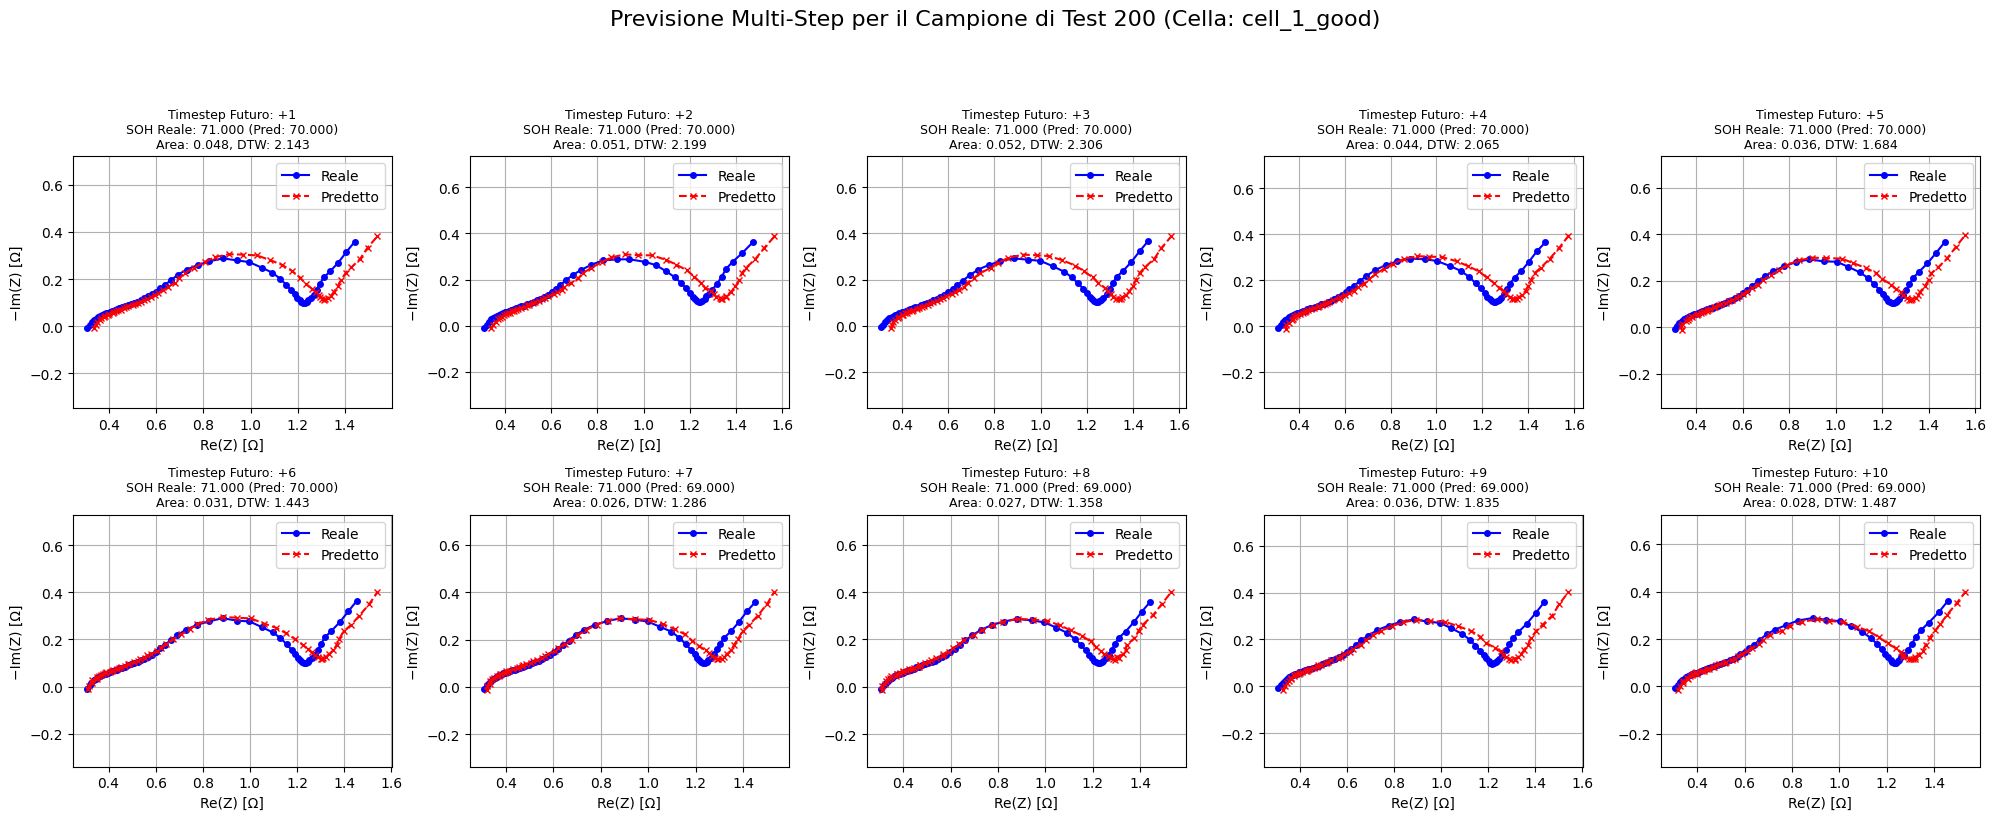

In [29]:
scalers_per_cell = load("scalers_per_cell.joblib")

print_eis_predictions(
    model=model,
    X_test_enc=X_test_enc,
    y_true_norm=y_test,
    scalers=scalers_per_cell,
    cell_ids_test=cell_ids_test, 
    index=200
)

In [36]:
model.save("encoder_transformer_customloss.keras")

In [9]:
model = tf.keras.models.load_model(
    "models_10/cell_5_good_ft.keras"
)


I0000 00:00:1762699850.437043  312584 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22162 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:00:10.0, compute capability: 8.9
/home/fcr/EIS-fitting/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 146 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
